In [7]:
import qutip
import matplotlib.pyplot as plt 
import numpy as np
import scipy.optimize as opt 
import scipy.linalg as linalg
import pickle
import time as time
import math, cmath
import sys; import time as time
import auxiliary_library as me

from IPython.display import display, Math, Latex
np.set_printoptions(threshold=1.e-9,linewidth=120,precision=3, formatter={"float":lambda x: str(.001*int(1000*x)) })

In [18]:
def vectorized_recursive_basis(depth_list, seed_ops_list, Hamiltonian, rho0):
    if np.all([isinstance(di,int) and di >= 0 for di in depth_list]):
        pass
    else:
        raise Exception("Incursive depth parameter must be natural") 
    
    

In [ ]:
def recursive_basis(depth, Hamiltonian, seed_op, rho0): 
    if type(depth == int):
        pass
    else:
        raise Exception("Incursive depth parameter must be integer")
    #if type(seed_op)
    basis = [seed_op]; loc_op = 0
    if type(depth == int):
        for i in range(1, depth):
            loc_op = qutip.Qobj(-1j * commutator(Hamiltonian, basis[i-1]))
            if (linalg.norm(loc_op) < 1e-10):
                print("Operator at depth", i, "is null")
                loc_op = None
                break
            loc_op = (loc_op * rho0).tr() - loc_op
            basis.append(loc_op)
    else:
        basis 
        raise Exception("Incursive depth parameter must be integer")
    return basis

In [5]:
N = 6; k_B = 1; temp = 5e-1; ts = np.linspace(0, 25,200)
spin_ops_list = me.one_body_spin_ops(N)
identity_op = spin_ops_list[0][0]

### Heisenberg Hamiltonian
chain_type = "XYZ"; Hamiltonian_paras = [.2, .15, .1, 1.]
H_H = me.Heisenberg_Hamiltonian(op_list = spin_ops_list, chain_type = chain_type,
                                size = N, Hamiltonian_paras = Hamiltonian_paras,
                                closed_bcs = True, visualization = False)

rho_tolerance = (-.5 * H_H).expm()
rho_tolerance = rho_tolerance/rho_tolerance.tr()

sigma_tolerance = (-.4 * H_H).expm()
sigma_tolerance = sigma_tolerance/sigma_tolerance.tr()

### classical operators 

cl_ops, label_ops = me.classical_ops(H_H, N, spin_ops_list, False)
magnetization = sum(spin_ops_list[3][a] for a in range(len(spin_ops_list[3])))
neel_operator = sum((-1)**a * spin_ops_list[3][a] for a in range(len(spin_ops_list[3])))

cl_ops["magnetization"] = magnetization; label_ops.append("magnetization")
cl_ops["neel_op"] = neel_operator; label_ops.append("neel_op")

print("Are all the operators Hermitian?:", me.basis_hermitian_check(cl_ops))
basis = [identity_op, cl_ops["x_op"]]

NameError: name 'np' is not defined

In [3]:
rhos = []
    
def callback(t, rhot):
    #global rho
    global rhos
    rho = rhot
    rhos.append(rhot)
    
    rhos = []    
    def callbacks(t, rhot):
        global rho
        global rhos
        rho = rhot
        rhos.append(rhot)

def exact_evolution(Hamiltonian, rho0, ts, obs):
    approx_exp_vals = []
    for t in ts:
        qutip.mesolve(Hamiltonian, rho0=rho0, tlist=np.linspace(t-1,t,1), c_ops=None, e_ops=callback)
        #newobs = [qutip.expect(rho, op) for op in obs]
        #approx_exp_vals.append(newobs)
    result = {}
    result["times"] = ts
    #result["averages"] = np.array(approx_exp_vals)
    result["state ev"] = rhos
    return result

In [7]:
def d_depth_proj_ev(initial_d, seed_op, size, Hamiltonian, basis, cl_ops_list, temp, ts, observables, 
                    visualize_H_evs, visualization_nonherm, visualize_expt_vals):
    
    ### building reference states and testing it
    start_time_1 = time.time()
    K_ref, rho_ref = me.build_reference_state(size = size, temp = temp, Hamiltonian = Hamiltonian,
                                       lagrange_op = seed_op, lagrange_mult = .1, svd = True)
    basis_incursive = me.recursive_basis(depth = initial_d, Hamiltonian = Hamiltonian,
                                                 seed_op = seed_op, rho0 = rho_ref)
    basis_orth = me.base_orth(ops = basis_incursive, rho0 = rho_ref, sc_prod = me.HS_inner_prod_r, 
                              visualization = False)
    
    ### test 2
    basis_orth, gram_matrix = me.basis_orthonormality_check(basis = basis_orth, 
                                                            rho0 = rho_ref, sc_prod = me.HS_inner_prod_r)
    
    ### constructing the initial state and H-tensor
    
    phi0, rho0 = me.build_rho0_from_basis(basis = basis_orth)
    Hijtensor = qutip.Qobj(me.H_ij_matrix(Hamiltonian = Hamiltonian, basis = basis_orth, 
                                           rho0 = rho_ref, sc_prod = me.HS_inner_prod_r)[1])
    if visualize_H_evs: 
        me.visz_H_tensor_evs(Htensor = Hijtensor)
        
    ### constructing the coefficient arrays and the physical states
    rhot_list = me.semigroup_phit_and_rhot_sol(phi0 = phi0, rho0 = rho0, Htensor = Hijtensor,
                                               ts = ts, basis = basis_orth)

    ### test 3
    herm_rhot_list = me.semigroup_rhos_test(rho_list = rhot_list, 
                                            visualization_nonherm = visualization_nonherm, ts = ts)
    
    ### Projected solution
    
    res_proj_ev = [np.array([qutip.expect(obs, rhot) for rhot in herm_rhot_list]) for obs in observables]
    print("Proj ev runtime = ", time.time() - start_time_1)
    
    ### Exact solution 
    
    start_time_2 = time.time()
    #res_exact = exact_evolution(Hamiltonian, rho0, ts, observables)
    #res_exact = qutip.mesolve(Hamiltonian, rho0=rho0, tlist=ts, c_ops=None, e_ops = observables)
    
    res_exact = qutip.mesolve(Hamiltonian, rho0=rho0, tlist=ts, 
                                   c_ops=None, e_ops=observables)
    res_exact_B = qutip.mesolve(Hamiltonian, rho0=rho0, tlist=ts, 
                                   c_ops=None, e_ops=None)
    
    print("Exact ev runtime = ", time.time() - start_time_2)
    
    if visualize_expt_vals:
        z = ts[:-1]
        fig3, ax3 = plt.subplots()
        ax3.plot(z, res_proj_ev[0], label = "Manifold-proj")
        ax3.plot(z, res_exact.expect[0][:-1], label = "Exact")
        ax3.legend(loc=0)
        ax3.set_title("Expected values for x_op - Exact v. Proj. ev. ")
        
        fig4, ax4 = plt.subplots()
        ax4.plot(z, res_proj_ev[1], label = "Manifold-proj")
        ax4.plot(z, res_exact.expect[1][:-1], label = "Exact")
        ax4.legend(loc = 0)
        ax4.set_title("Expected values for n_oc_op - Exact v. Proj. ev.")
        
        fig5, ax5 = plt.subplots()
        ax5.plot(z, res_proj_ev[2], label = "Manifold-proj")
        ax5.plot(z, res_exact.expect[2][:-1], label = "Exact")
        ax5.legend(loc = 0)
        ax5.set_title("Expected values for magnetization - Exact v. Proj. ev.")
    
    #max_diff_x = max(res_exact["averages"][:,0][:-1] - res_proj_ev[0])
    #max_diff_n_oc = max(res_exact["averages"][:,1][:-1] - res_proj_ev[1])
    #print(max_diff_x, max_diff_n_oc)
    
    if True:
        bures_exact_approx_list = [me.bures(herm_rhot_list[t], res_exact_B.states[t]) for t in range(len(herm_rhot_list))]
        relentropy_exact_approx_list = [me.rel_entropy(herm_rhot_list[t], res_exact_B.states[t]) for t in range(len(herm_rhot_list))]
        relentropy_exact_approx_list_prime = [me.rel_entropy(res_exact_B.states[t], herm_rhot_list[t]) for t in range(len(herm_rhot_list))]
        fig6, ax6 = plt.subplots()
        ax6.plot(ts[:-1], bures_exact_approx_list, label = "Bures metric")
        ax6.plot(ts[:-1], relentropy_exact_approx_list, label = "Relative entropy - Proj. v. Exact")
        ax6.plot(ts[:-1], relentropy_exact_approx_list_prime, label = "Relative entropy - Exact v. Proj.")
        ax6.legend(loc=0)
        ax6.set_title("Metrics - Exact and Proj. ev - d = 3 ops")
    
    return rho0, herm_rhot_list, res_exact, res_exact_B, res_proj_ev

The basis is orthonormal and hermitian
Proj ev runtime =  2.004918336868286
Proj ev runtime =  0.460735559463501


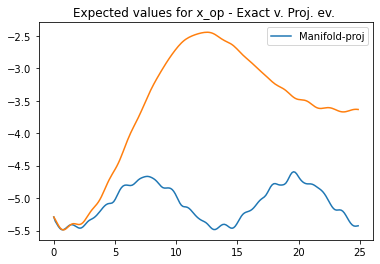

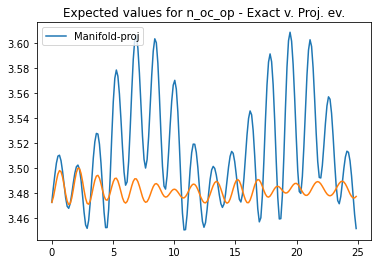

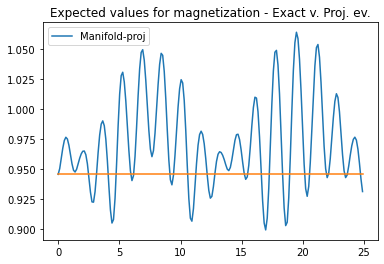

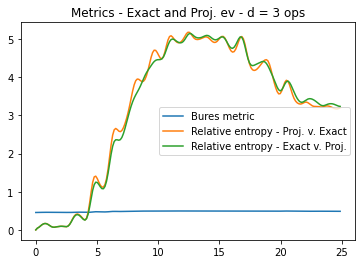

In [142]:
observables = [cl_ops["x_op"], cl_ops["n_oc_op"], cl_ops["magnetization"]]
rho0, herm_rhot_list, res_exact, res_exact_states, res_proj_ev = d_depth_proj_ev(initial_d = 7, seed_op = cl_ops["x_op"], size = N,
                                                               Hamiltonian = H_H, basis = basis, 
                                                               cl_ops_list = cl_ops, temp = temp, ts = ts,
                                                              observables = observables, visualize_H_evs = False, 
                                                               visualization_nonherm = False, visualize_expt_vals = True)

Not mean-normalized operator at 28 -th level
0.04808133104304273
Not mean-normalized operator at 32 -th level
0.04817525694187612
Not mean-normalized operator at 36 -th level
0.04831544629838307
Not mean-normalized operator at 40 -th level
0.04841130413332223
Not mean-normalized operator at 44 -th level
0.04847045600416262
Not mean-normalized operator at 48 -th level
0.04850569210852944
Not mean-normalized operator at 52 -th level
0.0485262510244995
Not mean-normalized operator at 56 -th level
0.04853805033286487
Not mean-normalized operator at 60 -th level
0.0485447253872421
Not mean-normalized operator at 64 -th level
0.048548454108872124
Not mean-normalized operator at 68 -th level
0.04855051455339327
Not mean-normalized operator at 72 -th level
0.04855164293699068
Not mean-normalized operator at 76 -th level
0.04855225643727258
Not mean-normalized operator at 80 -th level
0.04855258813203684
Not mean-normalized operator at 84 -th level
0.04855276671848015
Not mean-normalized operat

Proj ev runtime =  440.382675409317
Exact ev runtime =  1.6049449443817139


C:\Users\tomas\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
C:\Users\tomas\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
C:\Users\tomas\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


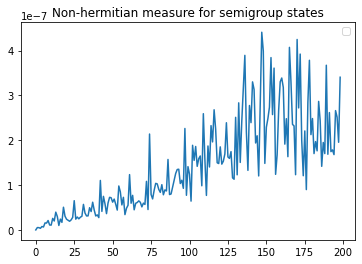

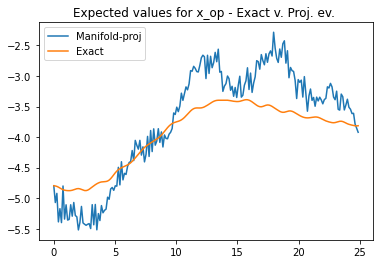

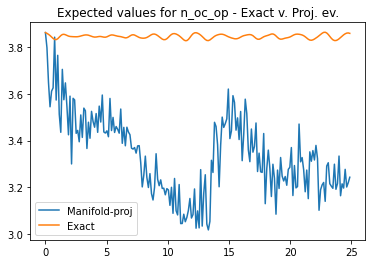

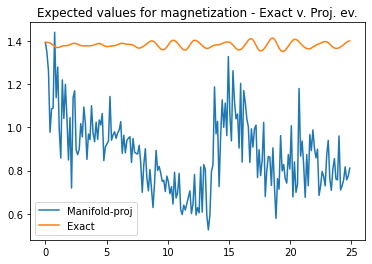

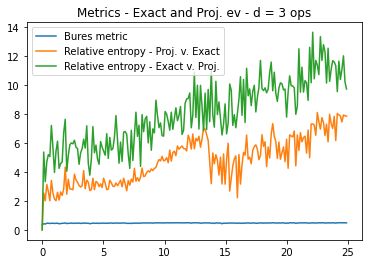

In [9]:
observables = [cl_ops["x_op"], cl_ops["n_oc_op"], cl_ops["magnetization"]]
rho0, herm_rhot_list, res_exact, res_exact_states, res_proj_ev = d_depth_proj_ev(initial_d = 250, seed_op = cl_ops["x_op"], size = N,
                                                               Hamiltonian = H_H, basis = basis, 
                                                               cl_ops_list = cl_ops, temp = temp, ts = ts,
                                                              observables = observables, visualize_H_evs = False, 
                                                               visualization_nonherm = True, visualize_expt_vals = True)

Not mean-normalized operator at 0 -th level
-0.8463777352966281
Not mean-normalized operator at 2 -th level
-0.0642403458182131
The basis is orthonormal and hermitian
Proj ev runtime =  1.0498831272125244
Exact ev runtime = 0.19078588485717773


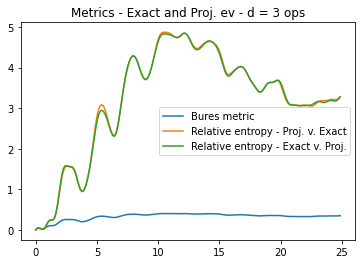

In [6]:
observables = [cl_ops["x_op"], cl_ops["n_oc_op"], cl_ops["magnetization"]]
rho0, herm_rhot_list, res_exact, res_proj_ev = d_depth_proj_ev(initial_d = 3, seed_op = cl_ops["x_op"], size = N,
                                                               Hamiltonian = H_H, basis = basis, 
                                                               cl_ops_list = cl_ops, temp = temp, ts = ts,
                                                              observables = observables, visualize_H_evs = False, 
                                                               visualization_nonherm = False, visualize_expt_vals = False)

Not mean-normalized operator at 0 -th level
1.0
The basis is orthonormal and hermitian
Proj ev runtime =  0.9521629810333252
Exact ev runtime = 0.22461962699890137


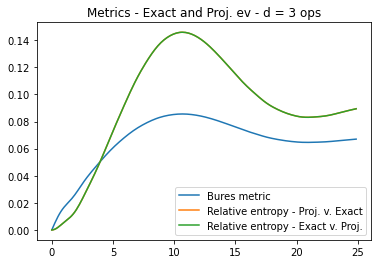

In [6]:
observables = [cl_ops["x_op"], cl_ops["n_oc_op"], cl_ops["magnetization"]]
rho0, herm_rhot_list, res_exact, res_proj_ev = d_depth_proj_ev(initial_d = 1, seed_op = cl_ops["magnetization"], size = N,
                                                               Hamiltonian = H_H, basis = basis, 
                                                               cl_ops_list = cl_ops, temp = temp, ts = ts,
                                                              observables = observables, visualize_H_evs = False, 
                                                               visualization_nonherm = False, visualize_expt_vals = False)

In [47]:
def LOCAL_build_reference_state(size, temp, Hamiltonian, lagrange_op, lagrange_mult):
    ### building the reference state
    k_B = 1; beta = 1/(k_B * temp); 
    K = -beta * ((1-lagrange_mult) * Hamiltonian - lagrange_mult * (lagrange_op - 1)**2)
    Kmax = max(linalg.eigvals(K).real)
    K = K/Kmax
    #K = K - Kmax * qutip.tensor([qutip.qeye(2) for k in range(size)]) 
    rho_ref = (K).expm()
    rho_ref = rho_ref/rho_ref.tr()
    
    if (me.is_density_op(rho_ref)):
        pass
    else:
        sys.exit("rho_ref: Not a valid density op")
    return rho_ref

seed_op = cl_ops["x_op"]
rho_ref = LOCAL_build_reference_state(size = N, temp = temp, Hamiltonian = H_H,
                                       lagrange_op = seed_op, lagrange_mult = .5)

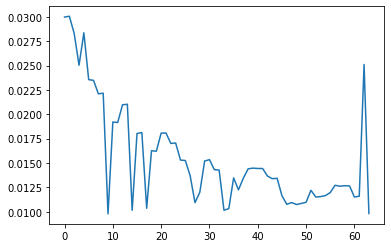

In [48]:
plt.plot(np.real(linalg.eig(rho_ref)[0]))

In [6]:
observables = [cl_ops["x_op"], cl_ops["n_oc_op"], cl_ops["magnetization"]]
RHO0, herm_rhot_list, res_exact, res_proj_ev = d_depth_proj_ev(8, N, H_H, basis, cl_ops, temp,ts, observables, False, False,False)

TypeError: d_depth_proj_ev() missing 1 required positional argument: 'visualize_expt_vals'

Not mean-normalized operator at 0 -th level
1.0000000000000002
The basis is orthonormal and hermitian
Proj ev runtime =  1.2212016582489014
Exact ev runtime = 0.358997106552124


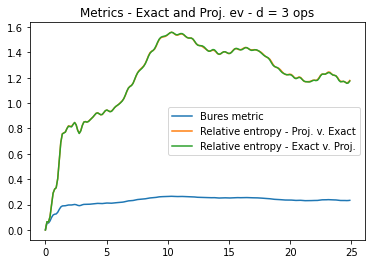

In [49]:
observables = [cl_ops["x_op"], cl_ops["n_oc_op"], cl_ops["magnetization"]]
RHO0, herm_rhot_list, res_exact, res_proj_ev = d_depth_proj_ev(3, N, H_H, basis, cl_ops, temp,ts, observables, False, False,False)

In [ ]:
if visualize_expt_vals:
        z = ts[:-1]
        fig3, ax3 = plt.subplots()
        ax3.plot(z, res_proj_ev[0], label = "Manifold-proj")
        ax3.legend(loc=0)
        ax3.set_title("Expected values for x_op - Exact v. Proj. ev. ")
        
        fig4, ax4 = plt.subplots()
        ax4.plot(z, res_proj_ev[1], label = "Manifold-proj")
        ax4.legend(loc = 0)
        ax4.set_title("Expected values for n_oc_op - Exact v. Proj. ev.")
        
        fig5, ax5 = plt.subplots()
        ax5.plot(z, res_proj_ev[2], label = "Manifold-proj")
        ax5.legend(loc = 0)
        ax5.set_title("Expected values for magnetization - Exact v. Proj. ev.")
        
        ax3.plot(z, res_exact["averages"][:,0][:-1], label = "Exact")
        ax4.plot(z, res_exact["averages"][:,1][:-1], label = "Exact")
        ax5.plot(z, res_exact["averages"][:,2][:-1], label = "Exact")
    

In [146]:
def visualize_avgs(ts, approx_avgs, exact_avgs):
    
    plt.subplots(nrows=len(observables), ncols = 1, sharex=True, sharey=True)
    z = ts[:-1]
    
    fig = plt.figure()
    ax=fig.add_subplot(111)
    ax.plot([1,2,3])
    
    n = len(fig.axes)
    for i in range(n):
    

IndentationError: expected an indented block (854761149.py, line 12)

In [125]:
me.rel_entropy

<function auxiliary_library.rel_entropy(rho, sigma)>

# Cosas para testear:

1. dos operadores con índices de recursividad d1 y d2, le ganan a un único operador de índice (d1+d2)?
2. como cuantificar el "poder" o el operador que más domina en la expansión? lambda más grande?
3. tiene sentido usar el algoritmo de Strassen acá?
4. plotear Bures y entropías relativas entre estados
5. intentar con funciones de dos puntos y Neels/Magnetizations

In [22]:
res_exact.states[50]

Quantum object: dims = [[2, 2, 2, 2, 2, 2], [2, 2, 2, 2, 2, 2]], shape = (64, 64), type = oper, isherm = True
Qobj data =
[[1.0 0.0 0.0 ... 0.0 0.0 0.0]
 [0.0 1.0 0.0 ... 0.0 0.0 0.0]
 [0.0 0.0 1.0 ... 0.0 0.0 0.0]
 ...
 [0.0 0.0 0.0 ... 1.0 0.0 0.0]
 [0.0 0.0 0.0 ... 0.0 1.0 0.0]
 [0.0 0.0 0.0 ... 0.0 0.0 1.0]]

In [11]:
help(qutip.mesolve)

Help on function mesolve in module qutip.mesolve:

mesolve(H, rho0, tlist, c_ops=None, e_ops=None, args=None, options=None, progress_bar=None, _safe_mode=True)
    Master equation evolution of a density matrix for a given Hamiltonian and
    set of collapse operators, or a Liouvillian.
    
    Evolve the state vector or density matrix (`rho0`) using a given
    Hamiltonian or Liouvillian (`H`) and an optional set of collapse operators
    (`c_ops`), by integrating the set of ordinary differential equations
    that define the system. In the absence of collapse operators the system is
    evolved according to the unitary evolution of the Hamiltonian.
    
    The output is either the state vector at arbitrary points in time
    (`tlist`), or the expectation values of the supplied operators
    (`e_ops`). If e_ops is a callback function, it is invoked for each
    time in `tlist` with time and the state as arguments, and the function
    does not use any return values.
    
    If eithe

In [40]:
res_exact = qutip.mesolve(H_H, qutip.tensor([qutip.qeye(2) for k in range(N)]), ts, observables)
res_exact.expect

[]

Not mean-normalized operator at 0 -th level
0.9999999999999996
The basis is orthonormal and hermitian
Proj ev runtime =  600.8061413764954
Exact ev runtime = 0.4521920680999756
1.9134943049588147 0.21700215860190264


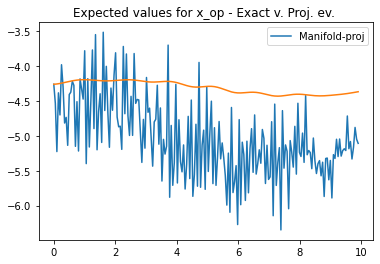

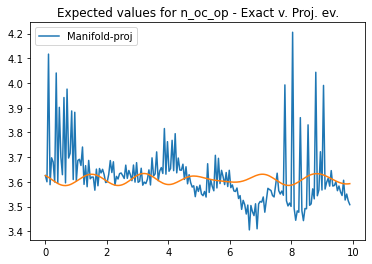

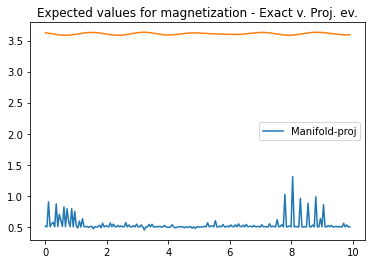

In [26]:
observables = [cl_ops["x_op"], cl_ops["n_oc_op"], cl_ops["magnetization"]]
res_exact, res_proj_ev = d_depth_proj_ev(140, N, H_H, basis, cl_ops, temp,ts, observables, False, False,True)

Not mean-normalized operator at 0 -th level
0.9999999999999996
The basis is orthonormal and hermitian
Proj ev runtime =  111.13796615600586
Exact ev runtime = 0.35938119888305664
3.3841708974383384 0.2290142847658041


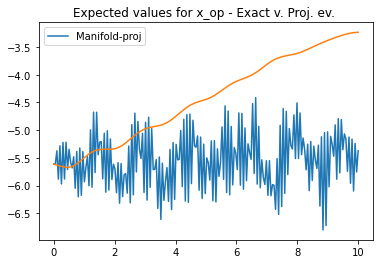

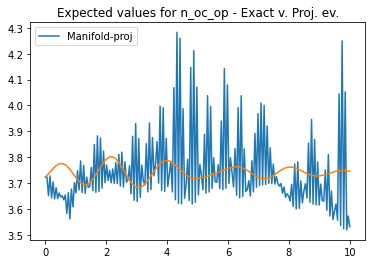

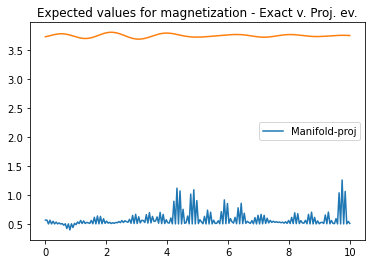

In [5]:
observables = [cl_ops["x_op"], cl_ops["n_oc_op"], cl_ops["magnetization"]]
res_exact, res_proj_ev = d_depth_proj_ev(60, N, H_H, basis, cl_ops, temp,ts, observables, False, False,True)

Not mean-normalized operator at 0 -th level
0.9999999999999996
Proj ev runtime =  666.7277171611786
Exact ev runtime = 0.423067569732666
0.5405832441382907 1.0346632542445597


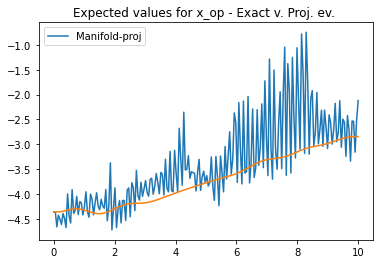

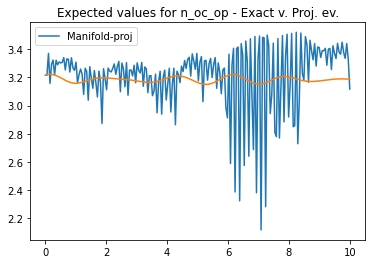

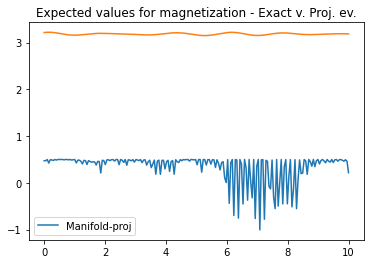

In [5]:
observables = [cl_ops["x_op"], cl_ops["n_oc_op"], cl_ops["magnetization"]]
res_exact, res_proj_ev = d_depth_proj_ev(135, N, H_H, basis, cl_ops, temp,ts, observables, False, False,True)

Not mean-normalized operator at 0 -th level
0.9999999999999996
Proj ev runtime =  446.95376205444336
Exact ev runtime = 0.3851950168609619
1.8648601449899411 0.7243882359499221


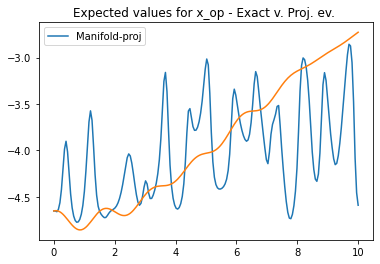

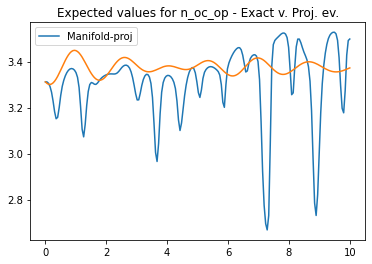

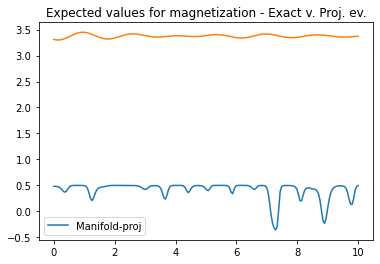

In [13]:
observables = [cl_ops["x_op"], cl_ops["n_oc_op"], cl_ops["magnetization"]]
res_exact, res_proj_ev = d_depth_proj_ev(100, N, H_H, basis, cl_ops, temp,ts, observables, False, False,True)